In [2]:
import numpy as np
import pandas as pd
import subprocess
import os
import sys
import argparse
import glob
import time
from astropy.io import fits as pyfits
import matplotlib.pyplot as plt
from urllib.request import urlopen
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.time import Time
from contextlib import closing
from astropy import units as u

In [3]:
# Getting all of the unaltered numpy arrays

foldername = 'ia_npy_arrays'
files = os.listdir(foldername)

foldername2 = 'ia_npy_luminosity_arrays'
files2 = os.listdir(foldername2)

In [4]:
def weighted_stack(df):
    """
    Given a dataframe that has a column named 'File Path' and 'RMS', stacks all of the npy arrays saved
    under the filepaths, weighted by the RMS
    """
    weighted_sum = None
    total_weight = 0


    rms_list = []
    for _, row in df.iterrows():
        file_path = row['File Path']
        rms = row['RMS']

        # Ensure file exists and RMS is valid
        if not isinstance(file_path, str) or not os.path.exists(file_path) or rms is None or rms <= 0 or np.isnan(rms):
            continue

        # Load the array and check its shape
        array = np.load(file_path)

        # Compute weight and accumulate
        weight = 1 / (rms ** 2)
        weighted_sum = array * weight if weighted_sum is None else weighted_sum + array * weight
        total_weight += weight
        rms_list.append(rms)

    print(rms_list)

    # Normalize to get the final stacked array
    return None if total_weight == 0 else weighted_sum / total_weight

Useful Functions

In [5]:
def process_array_for_rms(npy_array):

    try:
        # Load the NumPy array
        im = npy_array

        # 3-sigma clipping (find the root mean square of values that are not above 3 standard deviations)
        rms_temp = np.ma.std(im)
        keep = np.ma.abs(im) <= 3 * rms_temp
        rms = np.ma.std(im[keep])

        return rms

    except Exception as e:
        print(f"An error occurred while processing the array: {e}")
        return None

In [6]:
def calculate_luminosity(flux, redshift):
    """
    Calculate luminosity from flux and redshift.

    Parameters:
    - flux (float or np.ndarray): Flux in Janskys.
    - redshift.

    Returns:
    - np.ndarray: Luminosity in erg/s/Hz.
    """
    # Constants

    c = 3e5  # Speed of light in km/s
    H0 = 70  # Hubble constant in km/s/Mpc
    MPC_TO_CM = 3.0857e24  # 1 Mpc to cm
    JY_TO_ERG = 1e-23  # Jansky to erg/s/cm²/Hz
    FOUR_PI = 4 * np.pi

    # Calculate Approximate Distance
    dist_mpc = (c * redshift) / H0

    # Convert flux to erg/s/cm²/Hz
    flux_erg = flux * JY_TO_ERG

    # Convert distance to cm
    distance_cm = dist_mpc * MPC_TO_CM

    # Calculate luminosity
    luminosity = FOUR_PI * (distance_cm ** 2) * flux_erg
    return luminosity


See what types there are

In [7]:
full_df = pd.read_csv('full_data_april.csv')


In [8]:
type_counts = full_df['type'].value_counts().reset_index()
type_counts.columns = ['Type', 'Count']

type_counts

,Type,Count
0,SN Ia,19704
1,SN II,4208
2,SN IIn,761
3,SN Ia-91T,687
4,SN Ic,538
5,SN Ib,485
6,SN IIb,396
7,SN IIP,366
8,SLSN-I,235
9,SN Ic-BL,219


Load Dataframes for Different Types

In [9]:
ia_df = full_df[full_df['type'].str.contains('SN Ia', na=False)]
iin_df = full_df[full_df['type'].str.contains('SN IIn', na=False)]

In [10]:
stripped_envelope_types = ['SN IIb', 'SN Ib', 'SN Ic', 'SN Ib/c', 'SN Ic-BL']
strip_envelope_df = full_df[full_df['type'].isin(stripped_envelope_types)]

tde_df = full_df[full_df['type'].str.contains('TDE', na=False)]

ibn_icn_types =  ['SN Icn', 'SN Ibn']
ibn_icn_df = full_df[full_df['type'].isin(ibn_icn_types)]

slsn_1_df= full_df[full_df['type'] == 'SLSN-I']

slsn_2_df= full_df[full_df['type'] == 'SLSN-II']

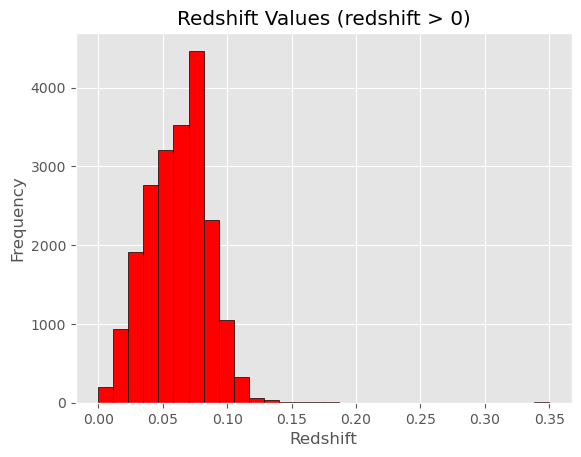

In [11]:


plt.hist(ia_df['redshift'], bins=30, edgecolor='black', color = "red")

# Labels and title
plt.xlabel('Redshift')
plt.ylabel('Frequency')
plt.title('Redshift Values (redshift > 0)')

# Show the plot
plt.show()

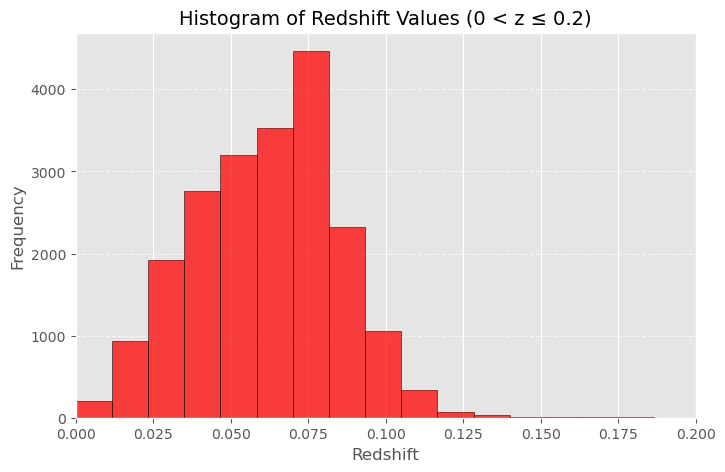

In [10]:
plt.style.use('ggplot')

# Create the histogram
plt.figure(figsize=(8, 5))
plt.hist(ia_df['redshift'], bins=30, edgecolor='black', color='#FF0404', alpha=0.75)

# Labels and title
plt.xlabel('Redshift', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Histogram of Redshift Values (0 < z ≤ 0.2)', fontsize=14)

# Limit x-axis range to 0 to 0.2
plt.xlim(0, 0.2)

# Improve grid visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [72]:
import matplotlib.pyplot as plt
import numpy as np

def plot_redshift_histogram(
    df,
    column='redshift',
    xlim=(0, 0.2),
    bin_width=0.01,
    title=None,
    color='#FF0404'
):
    plt.style.use('ggplot')

    # Create evenly spaced bins
    bins = np.arange(xlim[0], xlim[1] + bin_width, bin_width)

    # Create the histogram
    plt.hist(df[column], bins=bins, edgecolor='black', color=color, alpha=0.75)

    # Labels and title with serif font
    plt.xlabel('Redshift', fontsize=12, fontname='serif')
    plt.ylabel('Frequency', fontsize=12, fontname='serif')
    if title:
        plt.title(title, fontsize=14, fontname='serif')
    else:
        plt.title(f'Histogram of {column} Values', fontsize=14, fontname='serif')

    # Set x-axis limits
    plt.xlim(*xlim)

    # Improve grid visibility
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Show the plot
    plt.show()


In [73]:
from matplotlib import cm
def plot_binned_histogram(
    df,
    column,
    bin_ranges,
    bin_width=100,
    cmap_name='viridis',
    use_color=True,
    title=None  # Add this line
):
    # Filter out NaNs and keep only values ≥ 0
    values = df[column].dropna()
    values = values[values >= 0]

    # Create bin edges based on bin width
    bin_edges = np.arange(0, max(values) + bin_width, bin_width)

    # Create color palette from colormap
    color_palette = cm.get_cmap(cmap_name, len(bin_ranges))

    # Plot histogram
    counts, bins, patches = plt.hist(values, bins=bin_edges, edgecolor='black', alpha=0.85)

    if use_color:
        # Apply color based on bin_ranges
        for i, patch in enumerate(patches):
            bin_start = bins[i]
            bin_end = bins[i + 1]

            for j, (start, end) in enumerate(bin_ranges):
                if bin_start >= start and bin_end <= end:
                    patch.set_facecolor(color_palette(j))
                    break
    else:
        for patch in patches:
            patch.set_facecolor('crimson')

    # Labels and formatting
    plt.xlabel(column, fontsize=12, fontname='serif')
    plt.ylabel('Frequency', fontsize=12, fontname='serif')
    if title:
        plt.title(title, fontsize=14, fontname='serif')  # Use the provided title
    else:
        plt.title(f'{column} Binned Histogram', fontsize=14, fontname='serif')  # Fallback title
    plt.xlim(left=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


C:\Users\Jack Pope\AppData\Local\Temp\ipykernel_21660\1306187716.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = cm.get_cmap(cmap_name, len(bin_ranges))


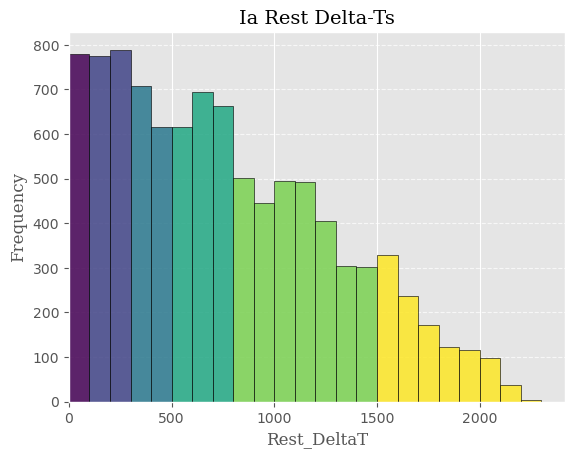

In [74]:
plot_binned_histogram(ia_df, 'Rest_DeltaT', [(0, 100), (100, 300), (300, 500), (500, 800), (800, 1500), (1500, 2500)], title = 'Ia Rest Delta-Ts')

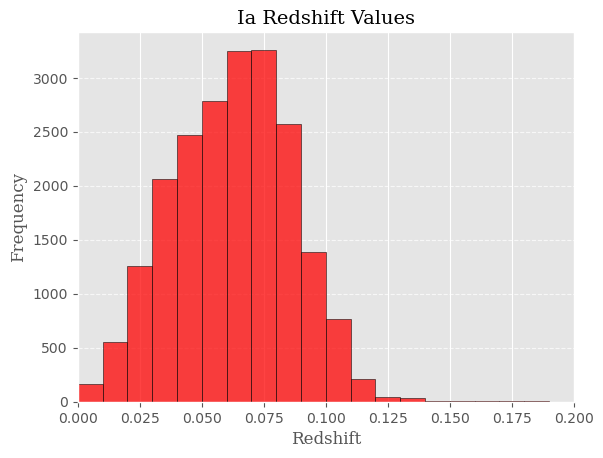

In [75]:
plot_redshift_histogram(ia_df, title = 'Ia Redshift Values')

C:\Users\Jack Pope\AppData\Local\Temp\ipykernel_21660\1306187716.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = cm.get_cmap(cmap_name, len(bin_ranges))


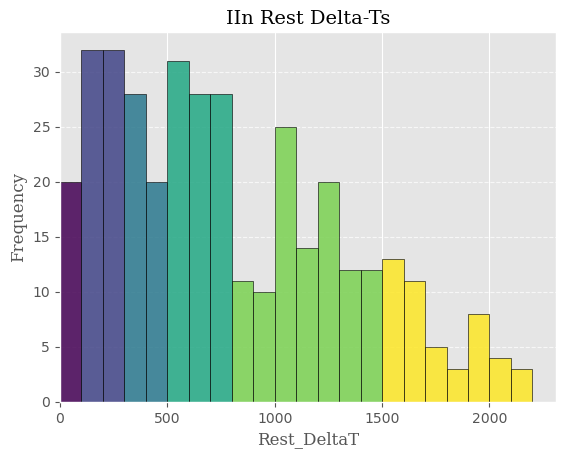

In [76]:
plot_binned_histogram(iin_df, 'Rest_DeltaT', [(0, 100), (100, 300), (300, 500), (500, 800), (800, 1500), (1500, 2500)], title = 'IIn Rest Delta-Ts')

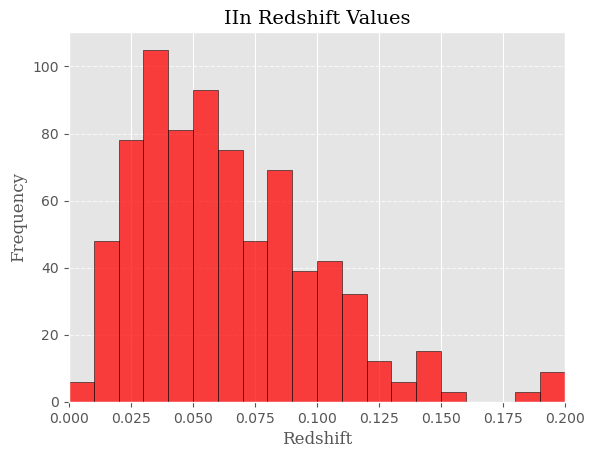

In [77]:
plot_redshift_histogram(iin_df, title = 'IIn Redshift Values')

C:\Users\Jack Pope\AppData\Local\Temp\ipykernel_21660\1306187716.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = cm.get_cmap(cmap_name, len(bin_ranges))


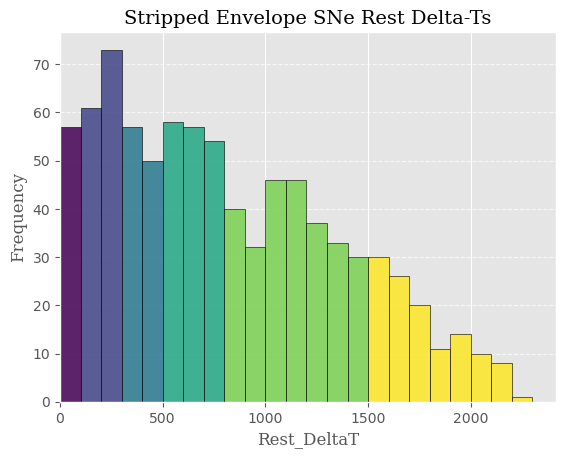

In [78]:
plot_binned_histogram(strip_envelope_df, 'Rest_DeltaT', [(0, 100), (100, 300), (300, 500), (500, 800), (800, 1500), (1500, 2500)],
                      title = 'Stripped Envelope SNe Rest Delta-Ts')


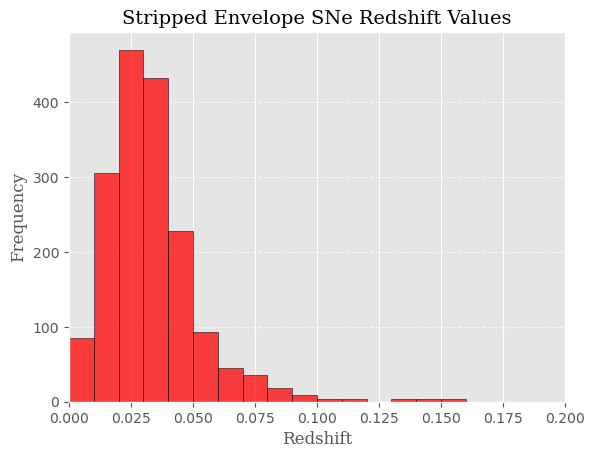

In [79]:
plot_redshift_histogram(strip_envelope_df, title = 'Stripped Envelope SNe Redshift Values')

C:\Users\Jack Pope\AppData\Local\Temp\ipykernel_21660\1306187716.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = cm.get_cmap(cmap_name, len(bin_ranges))


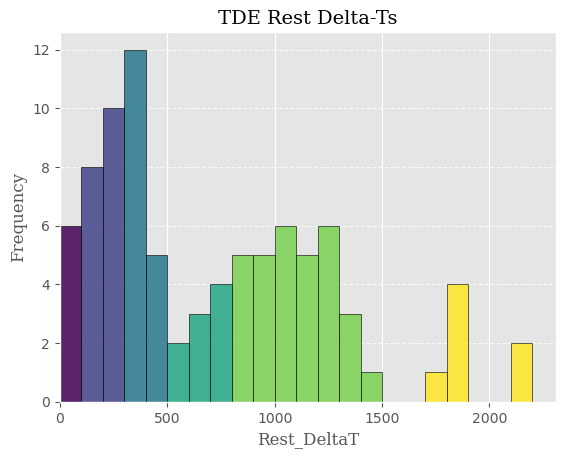

In [80]:
plot_binned_histogram(tde_df, 'Rest_DeltaT', [(0, 100), (100, 300), (300, 500), (500, 800), (800, 1500), (1500, 2500)],
                      title = 'TDE Rest Delta-Ts')

C:\Users\Jack Pope\AppData\Local\Temp\ipykernel_21660\1306187716.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = cm.get_cmap(cmap_name, len(bin_ranges))


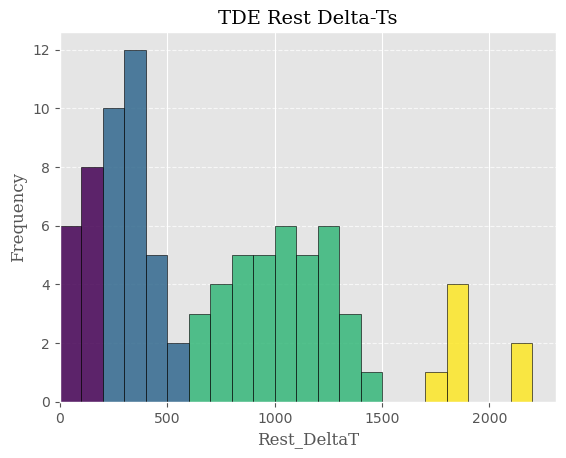

In [81]:
plot_binned_histogram(tde_df, 'Rest_DeltaT', [(0, 200), (200, 600), (600, 1500), (1500, 2600)],
                      title = 'TDE Rest Delta-Ts')

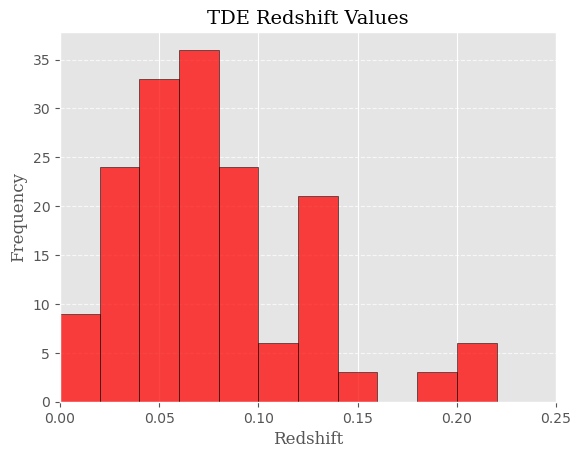

In [82]:
plot_redshift_histogram(tde_df, title = 'TDE Redshift Values', xlim = (0, 0.25), bin_width = 0.02)

C:\Users\Jack Pope\AppData\Local\Temp\ipykernel_21660\1306187716.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = cm.get_cmap(cmap_name, len(bin_ranges))


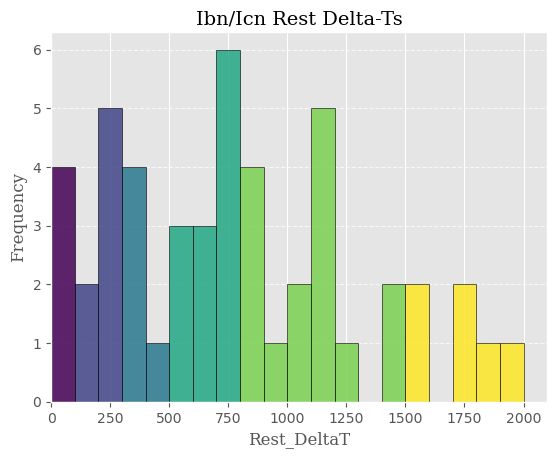

In [83]:
plot_binned_histogram(ibn_icn_df, 'Rest_DeltaT', [(0, 100), (100, 300), (300, 500), (500, 800), (800, 1500), (1500, 2500)],
                      title = 'Ibn/Icn Rest Delta-Ts')

C:\Users\Jack Pope\AppData\Local\Temp\ipykernel_21660\1306187716.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = cm.get_cmap(cmap_name, len(bin_ranges))


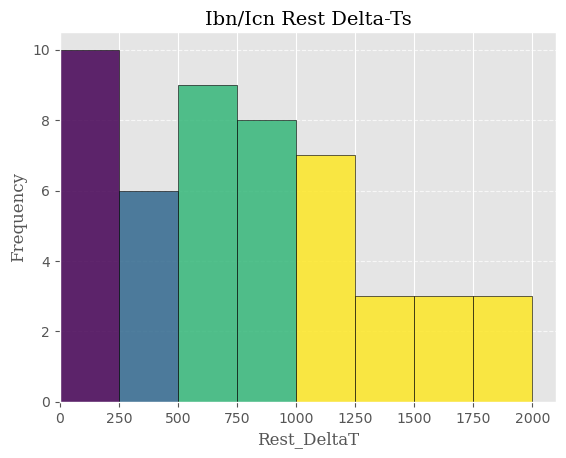

In [84]:
plot_binned_histogram(ibn_icn_df, 'Rest_DeltaT', [(0, 250), (250, 500), (500, 1000), (1000, 2500)], bin_width= 250,
                      title = 'Ibn/Icn Rest Delta-Ts')

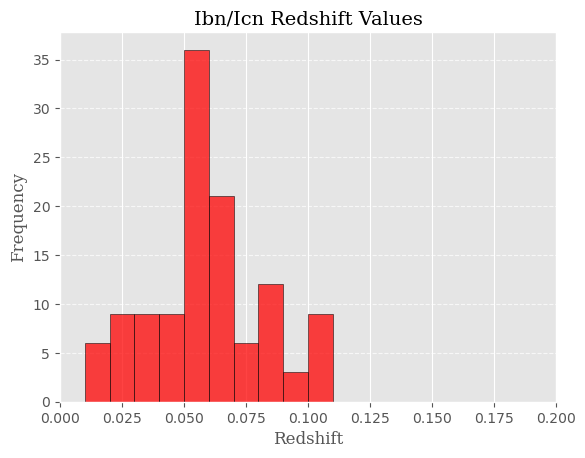

In [85]:
plot_redshift_histogram(ibn_icn_df, title = 'Ibn/Icn Redshift Values')

C:\Users\Jack Pope\AppData\Local\Temp\ipykernel_21660\1306187716.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = cm.get_cmap(cmap_name, len(bin_ranges))


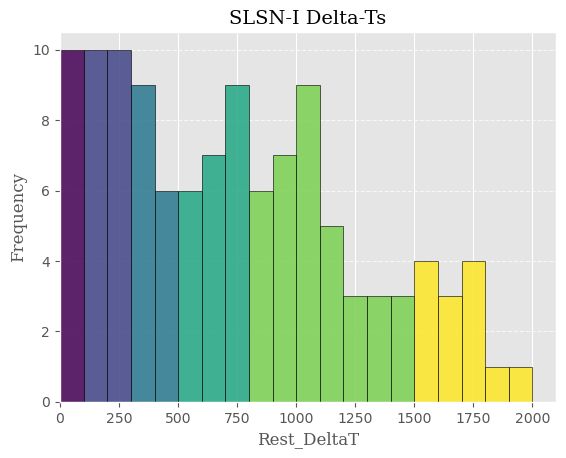

In [86]:
plot_binned_histogram(slsn_1_df, 'Rest_DeltaT', [(0, 100), (100, 300), (300, 500), (500, 800), (800, 1500), (1500, 2500)],
                      title = 'SLSN-I Delta-Ts')

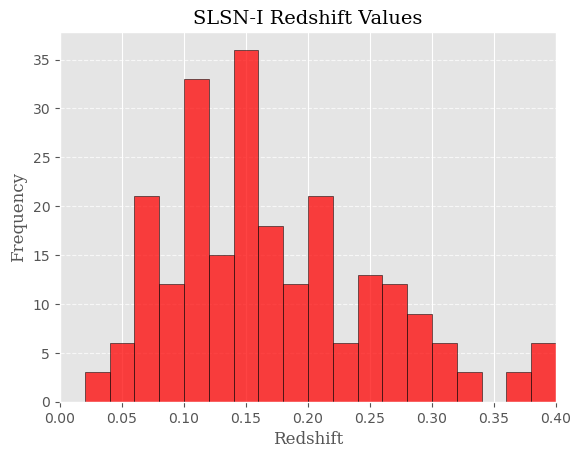

In [87]:
plot_redshift_histogram(slsn_1_df, title = 'SLSN-I Redshift Values', xlim = (0, 0.4), bin_width = 0.02)

C:\Users\Jack Pope\AppData\Local\Temp\ipykernel_21660\1306187716.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = cm.get_cmap(cmap_name, len(bin_ranges))


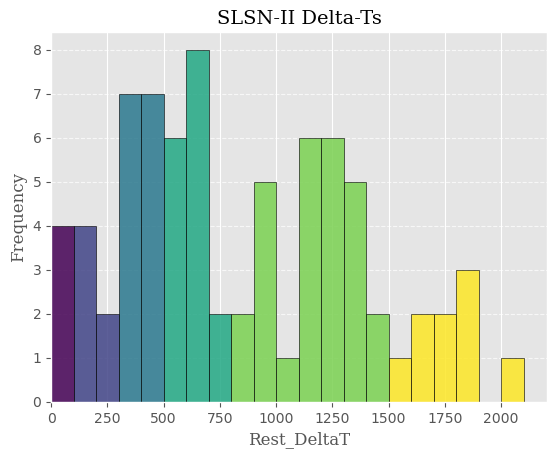

In [88]:
plot_binned_histogram(slsn_2_df, 'Rest_DeltaT', [(0, 100), (100, 300), (300, 500), (500, 800), (800, 1500), (1500, 2500)],
                      title = 'SLSN-II Delta-Ts')

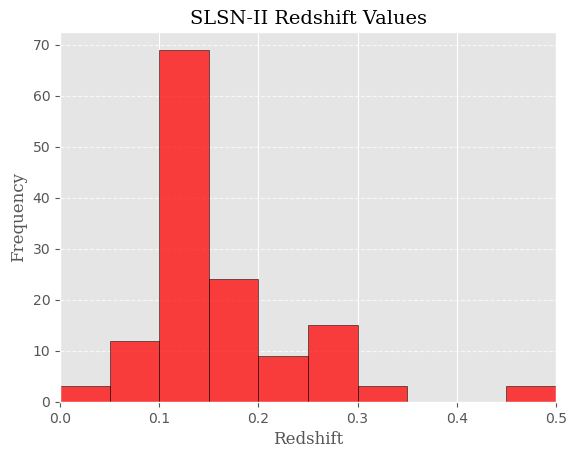

In [89]:
plot_redshift_histogram(slsn_2_df, title = 'SLSN-II Redshift Values', xlim = (0, 0.5), bin_width = 0.05)

list_dfs = [ia_df, iin_df, strip_envelope_df, tde_df, ibn_icn_df, slsn_1_df, slsn_2_df]

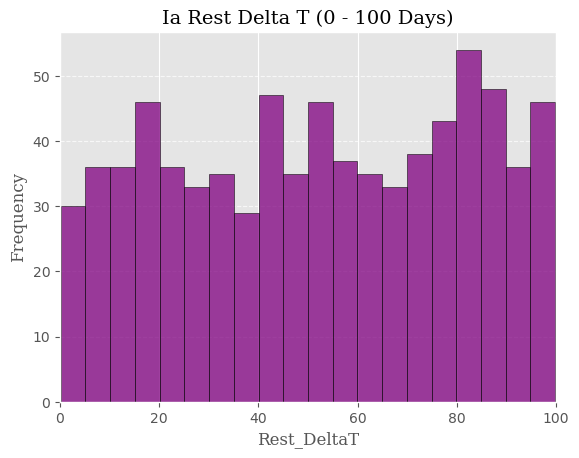

In [90]:

plt.style.use('ggplot')
# Filter Rest_DeltaT to include only values greater than or equal to 0 and less than 100
filtered_rest_delta_t = ia_df['Rest_DeltaT'].dropna()
filtered_rest_delta_t = filtered_rest_delta_t[(filtered_rest_delta_t >= 0) & (filtered_rest_delta_t <= 100)]

# Create the histogram with one color
plt.hist(filtered_rest_delta_t, bins=20, color='purple', edgecolor='black', alpha=0.75)

# Labels and title
plt.xlabel('Rest_DeltaT', fontsize=12, fontname = 'serif')
plt.ylabel('Frequency', fontsize=12, fontname = 'serif')
plt.title('Ia Rest Delta T (0 - 100 Days)', fontsize=14, fontname = 'serif')

# Set the x-axis to start at 0 and end at 100
plt.xlim(0, 100)

# Improve grid visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


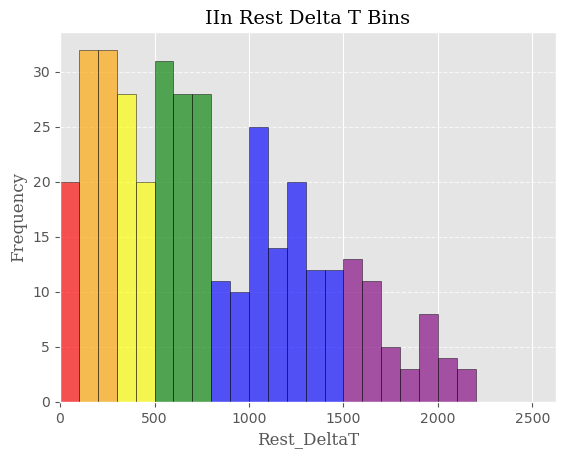

In [91]:
plt.style.use('ggplot')
# Filter Rest_DeltaT to include only values greater than or equal to 0
filtered_rest_delta_t = iin_df['Rest_DeltaT'].dropna()
filtered_rest_delta_t = filtered_rest_delta_t[filtered_rest_delta_t >= 0]

# Define the bin edges based on 100-wide bins
bin_edges = np.arange(0, 2501, 100)  # Now extends to 1600 to cover > 1500

# Create the histogram with the custom bin edges
counts, bins, patches = plt.hist(filtered_rest_delta_t, bins=bin_edges, edgecolor='black', alpha=0.65)

# Set colors with transparency for each bin based on the ranges
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']  # Adding purple for > 1500

# Apply the colors to the corresponding bins
for i, patch in enumerate(patches):
    # Determine which color the current bin belongs to
    if bins[i] < 100:
        patch.set_facecolor('red')
    elif bins[i] < 300:
        patch.set_facecolor('orange')
    elif bins[i] < 500:
        patch.set_facecolor('yellow')
    elif bins[i] < 800:
        patch.set_facecolor('green')
    elif bins[i] < 1500:
        patch.set_facecolor('blue')
    else:
        patch.set_facecolor('purple')  # For the last bin (values > 1500)

# Labels and title
plt.xlabel('Rest_DeltaT', fontsize=12, fontname = 'serif')
plt.ylabel('Frequency', fontsize=12, fontname = 'serif')
plt.title('IIn Rest Delta T Bins', fontsize=14, fontname='serif')
# Set the x-axis to start at 0
plt.xlim(left=0)

# Improve grid visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

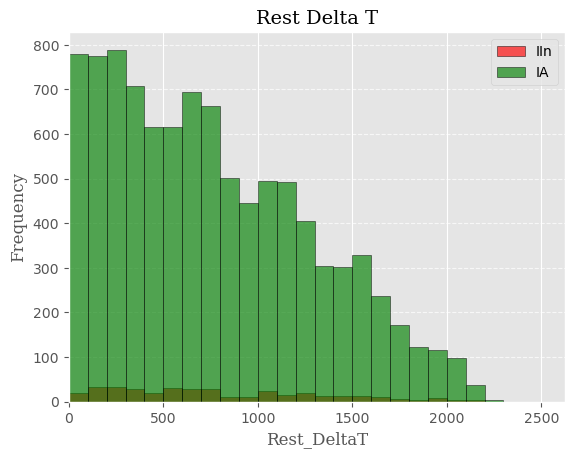

In [92]:
plt.style.use('ggplot')

# Filter Rest_DeltaT to include only values greater than or equal to 0
filtered_iin_rest_delta_t = iin_df['Rest_DeltaT'].dropna()
filtered_iin_rest_delta_t = filtered_iin_rest_delta_t[filtered_iin_rest_delta_t >= 0]

# Do the same for ia_df
filtered_ia_rest_delta_t = ia_df['Rest_DeltaT'].dropna()
filtered_ia_rest_delta_t = filtered_ia_rest_delta_t[filtered_ia_rest_delta_t >= 0]

# Define the bin edges based on 100-wide bins
bin_edges = np.arange(0, 2501, 100)

# Create the histogram for IIn (with red color)
counts_iin, bins_iin, patches_iin = plt.hist(filtered_iin_rest_delta_t, bins=bin_edges, edgecolor='black', alpha=0.65, color='red', label='IIn')

# Create the histogram for IA (with green color, for example)
counts_ia, bins_ia, patches_ia = plt.hist(filtered_ia_rest_delta_t, bins=bin_edges, edgecolor='black', alpha=0.65, color='green', label='IA')

# Set labels and title
plt.xlabel('Rest_DeltaT', fontsize=12, fontname='serif')
plt.ylabel('Frequency', fontsize=12, fontname='serif')
plt.title('Rest Delta T', fontsize=14, fontname='serif')

# Set the x-axis to start at 0
plt.xlim(left=0)

# Improve grid visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a legend to differentiate the two histograms
plt.legend()

# Show the plot
plt.show()


In [12]:
def stack_by_time_intervals(df, time_bins):
    """
    This function stacks arrays for each time interval in `time_bins`, computes the RMS for each stacked array,
    and returns a DataFrame with the results.
    
    Parameters:
    - df: DataFrame containing the data with a 'Rest_DeltaT' column (and any other necessary columns).
    - time_bins: List of tuples defining the time intervals [(min1, max1), (min2, max2), ...].
    
    Returns:
    - A DataFrame with columns ['time_interval', 'num_observations', 'rms', 'stacked_array'].
    """
    
    # List to store the results
    stacked_results = []

    # Loop through the time bins
    for t_min, t_max in time_bins:
        # Filter the dataframe for the current time bin
        subset_df = df[(df['Rest_DeltaT'] >= t_min) & (df['Rest_DeltaT'] < t_max)]
        
        if not subset_df.empty:
            # Get the stacked array for the current time bin
            stacked_array = weighted_stack(subset_df)
            
            # Calculate the RMS of the stacked array using the pre-defined function
            rms_value = process_array_for_rms(stacked_array) if stacked_array is not None else None
            
            # Store results in the list
            stacked_results.append({
                'time_interval': f"{t_min}-{t_max} days",
                'num_observations': len(subset_df),
                'rms': rms_value,
                'stacked_array': stacked_array
            })
        else:
            # Handle empty subsets
            stacked_results.append({
                'time_interval': f"{t_min}-{t_max} days",
                'num_observations': 0,
                'rms': None,
                'stacked_array': None
            })

    # Create a DataFrame from the results
    stacked_df = pd.DataFrame(stacked_results)

    return stacked_df


In [13]:
stacked_ia_df = stack_by_time_intervals(ia_df, [(0, 100), (100, 300), (300, 500), (500, 800), (800, 1500), (1500, 3000)])

[3.298417269643657e+27, 1.1644871541620685e+28, 1.462793912567829e+27, 1.5877830403152698e+28, 7.27261015760824e+27, 1.6590878764775806e+27, 1.3939928709602256e+28, 1.3318900635433683e+28, 9.620589002086184e+27, 8.971257370752412e+27, 8.149371173778449e+27, 8.502880399413924e+27, 1.0564571525534632e+28, 1.887447859682168e+27, 1.450237712767118e+28, 1.0385816801352072e+28, 1.6550312421407045e+28, 2.2923811981465243e+27, 1.732633160510431e+28, 2.091340558458514e+28, 1.5678131604494577e+28, 8.314661607187538e+27, 4.460215896628889e+27, 4.346902733481143e+27, 2.005046450972155e+28, 1.3165062672442068e+28, 1.478042700215209e+28, 2.1060116993649617e+28, 5.949618892392451e+27, 9.143136559031716e+27, 2.340698808414889e+28, 1.5721626716076094e+28, 1.1989405784374574e+28, 2.67194029412685e+27, 6.530358667654958e+27, 1.2220680527728998e+27, 3.774693043008684e+27, 2.5507062347996854e+27, 7.286515547728863e+27, 1.02963922246227e+28, 1.6911132191909565e+28, 8.316769188970604e+27, 4.251668449521882e+

In [14]:
stacked_iin_df = stack_by_time_intervals(iin_df, [(0, 100), (100, 300), (300, 500), (500, 800), (800, 1500), (1500, 3000)])

[1.863065387853708e+27, 4.1001563808469626e+27, 2.052644011160621e+28, 7.659951151845321e+27, 1.883621124003278e+28, 7.653925909510611e+27, 3.510697029794328e+27, 8.573952264488169e+27, 1.47759559493946e+27, 1.250659404055277e+28, 8.147705129528216e+27, 4.9114545101238167e+27, 1.3929041682821258e+26, 3.705787160579326e+28, 5.978754363792824e+27, 2.788597179567976e+28, 1.3443911421633974e+27, 7.947654232440368e+27, 7.615144135254214e+27, 1.1557553570534492e+28]
[3.3047898932725267e+27, 5.697338060349153e+27, 2.3198810021442788e+27, 2.559593511243394e+27, 1.703352748387992e+28, 1.033306309469898e+28, 8.311923275116639e+26, 9.641036125067772e+27, 1.2868291495088166e+27, 4.252945182564245e+27, 2.3880705416480597e+27, 1.0065014625704833e+28, 9.893201243080162e+27, 2.028832909454719e+28, 8.357219474284715e+28, 7.320702915243183e+27, 1.62764778782546e+27, 1.1904592702038472e+28, 9.54667788096493e+27, 1.7265601766308918e+28, 3.056101582166115e+28, 1.2661158516833792e+28, 2.7654536278057844e+28

In [15]:
stacked_stripped_envelope_df = stack_by_time_intervals(strip_envelope_df,
                                                       [(0, 100), (100, 300), (300, 500), (500, 800), (800, 1500), (1500, 3000)])

[5.50395762201075e+27, 1.3625542222072802e+26, 3.3155117625945254e+27, 2.169106358290872e+27, 1.8318216326660545e+27, 1.0927568549061889e+27, 7.339527894575937e+27, 1.8769610069046253e+27, 7.430016050053653e+27, 8.204371360551327e+26, 4.868143703055459e+27, 3.382908458654819e+27, 4.055905042797143e+27, 4.30616766590148e+27, 3.1121867944762863e+27, 3.1389582245332016e+27, 6.513432755534315e+28, 1.2430628814124546e+27, 1.5246413466352427e+27, 2.2771726765199132e+27, 3.3332963390262547e+27, 2.049707491335004e+27, 3.201872492602309e+26, 7.286126381090971e+27, 3.750176122064387e+27, 1.607610681556391e+27, 1.967964433582896e+27, 3.227848183819328e+27, 3.383165697062517e+27, 2.646974557163755e+27, 5.810733129833812e+26, 3.002673938362989e+27, 2.612256327952883e+27, 2.523028797213616e+27, 2.231034358304316e+27, 2.612768402847041e+25, 2.470120677654776e+27, 1.5003673091245825e+27, 1.451701948841088e+27, 2.0646080614308875e+27, 6.0871281494561065e+26, 2.0667058040987148e+27, 3.902510252614185e+2

In [16]:
stacked_tde_df = stack_by_time_intervals(tde_df, [(0, 100), (100, 300), (300, 500), (500, 800), (800, 1500), (1500, 3000)])

[2.1643678458702457e+27, 2.584566522884207e+28, 4.571932198106268e+28, 1.843593539115372e+28, 2.155238225807971e+29, 4.178310282550006e+28]
[2.103290434909743e+28, 2.3904990281331878e+28, 1.5183624984971464e+28, 3.186944147090481e+29, 8.254935903871435e+28, 1.0736099356796844e+27, 6.6810391002797166e+28, 1.3171028409406797e+28, 9.4444037565049e+27, 2.1627411656845467e+28, 4.33767415676723e+29, 4.897177828618774e+28, 2.4099969459980065e+28, 9.44201919009433e+27, 7.86452121435729e+27, 9.167305872535832e+27, 4.7462231360466525e+28, 1.018210355382962e+28]
[2.4031906430073503e+27, 1.5170031507649367e+28, 8.698767410188414e+27, 1.0452844062378314e+28, 1.356997801029793e+28, 5.252152004133752e+28, 1.4072635754414283e+27, 9.503038189828746e+27, 2.507680323958277e+28, 6.380513274763901e+27, 8.775643559593001e+28, 3.11040906280676e+28, 2.7999651966976364e+28, 9.925104094135043e+27, 1.885721915626928e+28, 1.9126656440895003e+28, 1.0115167054560829e+28]
[1.4231523840873162e+29, 6.715698327156675e+

In [17]:
stacked_ibn_icn_df = stack_by_time_intervals(ibn_icn_df, [(0, 250), (250, 500), (500, 1000), (1000,3000)])

[1.2373424723329576e+27, 1.0709187954564028e+28, 7.880176266409812e+27, 1.4618045013188397e+28, 3.832725315059529e+28, 2.0367925374052016e+28, 6.553446225399819e+27, 3.866110370248507e+27, 1.4177307494893386e+27, 1.0050258951431805e+28]
[1.187146204627115e+28, 5.269518006206593e+27, 1.831640611277642e+28, 3.0933568851749428e+28, 1.728843355364478e+28, 7.009775028053637e+27]
[1.190230249964976e+28, 9.728768892670372e+27, 9.024203240552164e+27, 9.623886373071796e+27, 4.7732472244611e+27, 6.375638941361963e+27, 2.757742383893852e+28, 7.791866315432546e+27, 1.9917827807891323e+28, 1.0389087206713807e+28, 1.3471733750044888e+28, 2.2593253531726906e+28, 1.718907544545335e+27, 2.740063032294722e+28, 3.075979859806876e+27, 1.542992603096045e+28, 2.886860757980459e+27]
[8.733894112908737e+27, 8.134341975497864e+27, 1.1030484600435971e+27, 9.424998263079698e+26, 8.021856079470261e+27, 1.621685563390854e+27, 1.0592976091773563e+28, 8.946971529919243e+27, 5.135568677276412e+27, 7.076011975981014e+

In [18]:
stacked_slsn1_df = stack_by_time_intervals(slsn_1_df, [(0, 100), (100, 300), (300, 500), (500, 800), (800, 1500), (1500, 3000)])

[8.584050268115992e+28, 1.8768200562387155e+28, 4.065620335540572e+29, 1.3797688844002275e+28, 1.0039422749696337e+29, 1.764998136765064e+29, 3.71654540909603e+29, 5.539856502043712e+28, 6.230927425402324e+28, 1.7217336009791536e+29]
[5.785072426063419e+28, 2.726108962445848e+28, 1.997279771261617e+29, 1.476576299106534e+29, 7.178155571918422e+28, 2.258856296653893e+29, 1.4940792517099698e+29, 2.100775284454073e+29, 5.02361600216906e+28, 6.241141715495185e+28, 1.2386866621388148e+29, 7.217765669697446e+28, 1.0387986526134065e+28, 5.549600814994286e+28, 3.018707833352286e+29, 2.770477999093955e+29, 2.1201988822201555e+29, 1.323027491435674e+28, 8.863677191644761e+27]
[7.65559381210367e+28, 2.469719902169877e+29, 9.745483342616685e+28, 1.3273492923964704e+29, 1.540258854296059e+29, 1.64242825128933e+28, 3.3345443417769506e+29, 7.249305525155305e+28, 3.233481757915989e+28, 1.3540029029722855e+29, 2.215360864299238e+29, 2.7603594112990147e+29, 4.315646302878026e+28, 1.2000392366419895e+29,

In [19]:
stacked_slsn2_df = stack_by_time_intervals(slsn_2_df, [(0, 100), (100, 300), (300, 500), (500, 800), (800, 1500), (1500, 3000)])

[3.4603669724102006e+28, 4.825979748774467e+28, 2.7234234936083634e+28, 3.196503620880119e+28]
[5.0034791895546255e+28, 1.118231727926095e+29, 3.56847021822373e+29, 3.74634149317776e+28, 6.2391198880176846e+29, 6.229497885971806e+28]
[8.102550699812341e+28, 2.386708158949465e+28, 4.272697762872806e+28, 3.2919617685013685e+28, 1.2909966056652373e+28, 1.3260560676859162e+29, 3.834544665541453e+28, 5.03187788036906e+28, 5.803969862186569e+28, 4.619629167436593e+28, 5.004593093853163e+28, 9.930208359202231e+26, 1.0113485615971911e+29, 2.033254041785707e+28]
[7.829365541304772e+28, 6.643299013845536e+28, 6.59855954728767e+28, 1.0544017802154164e+29, 1.4044335378796835e+29, 3.393221698639518e+28, 1.3680210252839072e+29, 1.123747728708769e+29, 2.050882753240268e+29, 2.201160410339478e+29, 6.275733782723356e+29, 5.513485627826345e+28, 5.794754831083014e+28, 6.559345577236577e+28, 4.374406898877896e+28, 2.3656398278603182e+29]
[7.7212333595185135e+28, 1.92705859525956e+28, 7.963215167409825e+28

In [20]:
plt.style.use('default')

In [21]:
tde_df

,Name,Epoch,RA,Dec,type,redshift,Distance_Mpc,Rest_DeltaT,RMS,File Path
3,ZTF17aaazdba,1,08:13:16.95,+22:38:53.9,TDE,0.0220,94.285714,49.882583,2.164368e+27,luminosity_arrays_2_april\ZTF17aaazdba_epoch_1...
4,ZTF17aaazdba,2,08:13:16.95,+22:38:53.9,TDE,0.0220,94.285714,1002.915851,1.557547e+27,luminosity_arrays_2_april\ZTF17aaazdba_epoch_2...
5,ZTF17aaazdba,3,08:13:16.95,+22:38:53.9,TDE,0.0220,94.285714,1857.123288,1.369057e+27,luminosity_arrays_2_april\ZTF17aaazdba_epoch_3...
30,ZTF18aabdajx,1,12:20:45.07,+49:33:04.6,TDE,0.0284,121.714286,-1512.660443,1.799801e+27,luminosity_arrays_2_april\ZTF18aabdajx_epoch_1...
31,ZTF18aabdajx,2,12:20:45.07,+49:33:04.6,TDE,0.0284,121.714286,-554.861921,2.722361e+27,luminosity_arrays_2_april\ZTF18aabdajx_epoch_2...
...,...,...,...,...,...,...,...,...,...,...
27176,ZTF24aajvvhj,2,10:31:38.90,+34:54:30.0,TDE,0.1200,514.285714,-768.143415,3.616254e+28,luminosity_arrays_2_april\ZTF24aajvvhj_epoch_2...
27177,ZTF24aajvvhj,3,10:31:38.90,+34:54:30.0,TDE,0.1200,514.285714,80.963728,4.178310e+28,luminosity_arrays_2_april\ZTF24aajvvhj_epoch_3...
27901,ZTF24aatxshz,1,18:14:06.19,+36:14:59.7,TDE,0.1398,599.142857,-2125.263367,5.354528e+28,luminosity_arrays_2_april\ZTF24aatxshz_epoch_1...
27902,ZTF24aatxshz,2,18:14:06.19,+36:14:59.7,TDE,0.1398,599.142857,-1197.907690,5.665459e+28,luminosity_arrays_2_april\ZTF24aatxshz_epoch_2...


In [23]:
filtered_df = tde_df[(tde_df['Rest_DeltaT'] >= 300) & (tde_df['Rest_DeltaT'] <= 500)]


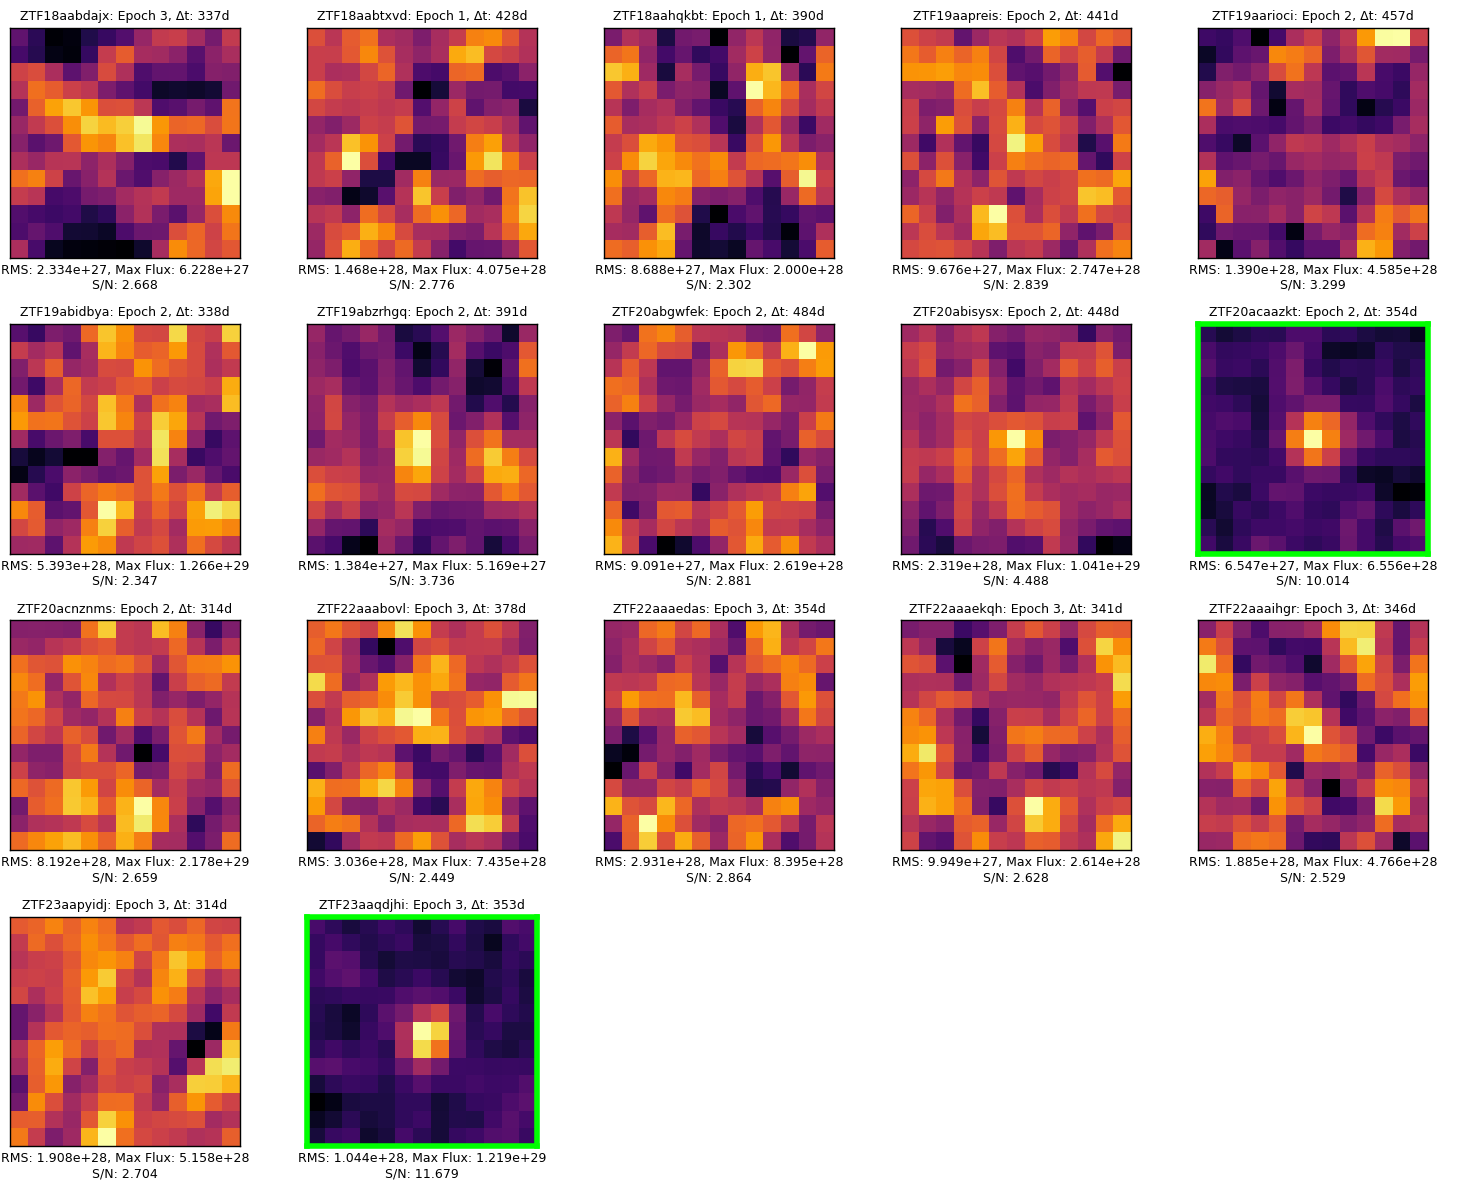

In [43]:
import numpy as np
import matplotlib.pyplot as plt

file_paths = filtered_df['File Path'].tolist()
n = len(file_paths)
ncols = 5
nrows = (n + ncols - 1) // ncols

fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3))

# Make sure axs is always 2D for consistent indexing
axs = np.array(axs)
if axs.ndim == 1:
    axs = axs.reshape(1, -1)

for i, path in enumerate(file_paths):
    row = i // ncols
    col = i % ncols
    ax = axs[row, col]

    arr = np.load(path)
    rms = process_array_for_rms(arr)
    max_flux = arr.max()
    snr = max_flux / rms

    # Metadata
    name = filtered_df.iloc[i]['Name']
    epoch = filtered_df.iloc[i]['Epoch']
    delta_t = filtered_df.iloc[i]['Rest_DeltaT']

    # Plot image
    ax.imshow(arr, cmap='inferno', interpolation='nearest')
    ax.set_title(f"{name}: Epoch {epoch}, Δt: {delta_t:.0f}d", fontsize=9)

    ax.set_xlabel(
        "RMS: {:.3e}, Max Flux: {:.3e}\nS/N: {:.3f}".format(rms, max_flux, snr),
        fontsize=9,
        color='black'
    )

    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

    # Orange border for S/N > 5
    if snr > 5:
        for spine in ax.spines.values():
            spine.set_edgecolor('lime')
            spine.set_linewidth(4)
    else:
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1)

# Hide unused subplots
for j in range(i + 1, nrows * ncols):
    row = j // ncols
    col = j % ncols
    ax = axs[row, col]
    ax.axis('off')

plt.tight_layout()
plt.show()


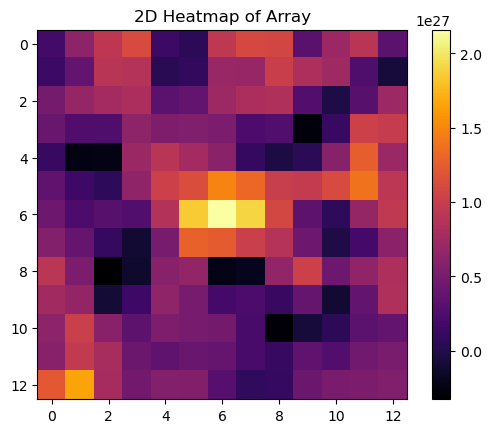

In [22]:
plt.imshow(stacked_iin_df['stacked_array'][5], cmap='inferno', interpolation='nearest')
plt.colorbar()  # Show color bar
plt.title("2D Heatmap of Array")
plt.show()

In [22]:
stacked_ia_df = stacked_ia_df[1:]

In [87]:
import numpy as np
import matplotlib.pyplot as plt

def plot_stacked_arrays(df, title = None, array_col='stacked_array',
                         time_col='time_interval', rms_col='rms',
                         count_col = 'num_observations', cmap='inferno'):
    """
    Plots stacked arrays from a DataFrame with a unified color scale and displays the RMS, S/N, and the number of stacked images.
    Adds a lime outline (thickness 4) for plots with S/N >= 5.

    Parameters:
    - df: DataFrame containing the stacked arrays, time intervals, and RMS values.
    - array_col: Column name for the stacked arrays.
    - time_col: Column name for the time intervals.
    - rms_col: Column name for the RMS values.
    - count_col: Column name for the number of stacked images.
    - cmap: Colormap for visualization (default: 'inferno').
    - plot_title: Title for the entire plot (default: 'Unified Scaling').

    Returns:
    - Displays the plot.
    """
    plt.style.use('default')
    num_arrays = len(df)
    ncols = 3
    nrows = (num_arrays // ncols) + (num_arrays % ncols > 0)

    # Determine min and max for unified scaling
    vmin = np.min([np.min(arr) for arr in df[array_col]])
    vmax = np.max([np.max(arr) for arr in df[array_col]])

    # Create subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))
    axes = axes.flatten()  # Flatten axes for easier indexing

    # Plot each array
    for i, ax in enumerate(axes):
        if i < num_arrays:
            arr = df.iloc[i][array_col]
            rms = df.iloc[i][rms_col]
            max_flux = np.max(arr)
            snr = max_flux / rms if rms != 0 else np.nan  # Calculate S/N

            # Plot the array with unified color scaling
            im = ax.imshow(arr, cmap=cmap, interpolation='nearest', vmin=vmin, vmax=vmax)
            ax.set_title(f"Time: {df.iloc[i][time_col]}", fontsize=10)

            # Display labels without LaTeX or bold formatting
            ax.set_xlabel(f"RMS: {rms:.3e}, Stacked: {df.iloc[i][count_col]}\nMax Flux: {max_flux:.3e}, S/N: {snr:.3f}", 
                          fontsize=9, color='black')
            ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

            # Lime outline for S/N >= 5
            if snr >= 5:
                for spine in ax.spines.values():
                    spine.set_edgecolor('lime')
                    spine.set_linewidth(4)
            else:
                for spine in ax.spines.values():
                    spine.set_edgecolor('black')
                    spine.set_linewidth(1)

        else:
            ax.axis('off')

    # Use the plot_title argument for the title of the whole plot
    fig.suptitle(title, fontsize=14, fontweight='bold', color='black', x=0.45, y=0.98)

    # Add a color bar in a separate axis
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cbar_ax, label="Intensity erg/sec/cm^2/Hz")

    # Adjust layout to add more space between rows (increase hspace)
    plt.subplots_adjust(top=0.90, hspace=0.4)  # Increase hspace for more vertical space

    plt.tight_layout(rect=[0, 0, 0.9, 1])  # Ensure space for the color bar
    plt.show()


In [83]:
plt.rc('text', usetex=True)

def plot_stacked_arrays_individual_scaling(df, title = None, array_col='stacked_array', 
                                           time_col='time_interval', rms_col='rms',
                                           count_col='num_observations', cmap='inferno'):
    """
    Plots stacked arrays from a DataFrame with individual color scaling for each subplot, 
    displays the RMS, S/N, and number of stacked images below each subplot.
    Adds a lime outline (thickness 4) for plots with S/N >= 5.

    Parameters:
    - df: DataFrame containing the stacked arrays, time intervals, and RMS values.
    - array_col: Column name for the stacked arrays.
    - time_col: Column name for the time intervals.
    - rms_col: Column name for the RMS values.
    - count_col: Column name for the number of stacked images.
    - cmap: Colormap for visualization (default: 'inferno').

    Returns:
    - Displays the plot.
    """
    plt.style.use('default')
    num_arrays = len(df)
    ncols = 3
    nrows = (num_arrays // ncols) + (num_arrays % ncols > 0)

    # Create subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))
    axes = axes.flatten()

    # Plot each array
    for i, ax in enumerate(axes):
        if i < num_arrays:
            arr = df.iloc[i][array_col]
            vmin = np.min(arr)
            vmax = np.max(arr)

            rms = df.iloc[i][rms_col]
            max_flux = np.max(arr)
            snr = max_flux / rms if rms != 0 else np.nan

            im = ax.imshow(arr, cmap=cmap, interpolation='nearest', vmin=vmin, vmax=vmax)
            ax.set_title(f"Time: {df.iloc[i][time_col]}", fontsize=10)

            # Add detailed label
            ax.set_xlabel(
                f"RMS: {rms:.3e}, Stacked: {df.iloc[i][count_col]}\n"
                f"Max Flux: {max_flux:.3e}, S/N: {snr:.3f}",
                fontsize=9, color='black'
            )
            ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

            # Lime outline for S/N >= 5
            if snr >= 5:
                for spine in ax.spines.values():
                    spine.set_edgecolor('lime')
                    spine.set_linewidth(4)
            else:
                for spine in ax.spines.values():
                    spine.set_edgecolor('black')
                    spine.set_linewidth(1)

        else:
            ax.axis('off')

    fig.suptitle(title, fontsize=14, fontweight='bold', color='black', x=0.45, y=0.98)

    # Adjust layout to add more space between rows (increase hspace)
    plt.subplots_adjust(top=0.90, hspace=0.4)  # Increase hspace for more vertical space

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()



C:\Users\Jack Pope\AppData\Local\Temp\ipykernel_14488\955971619.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Ensure space for the color bar


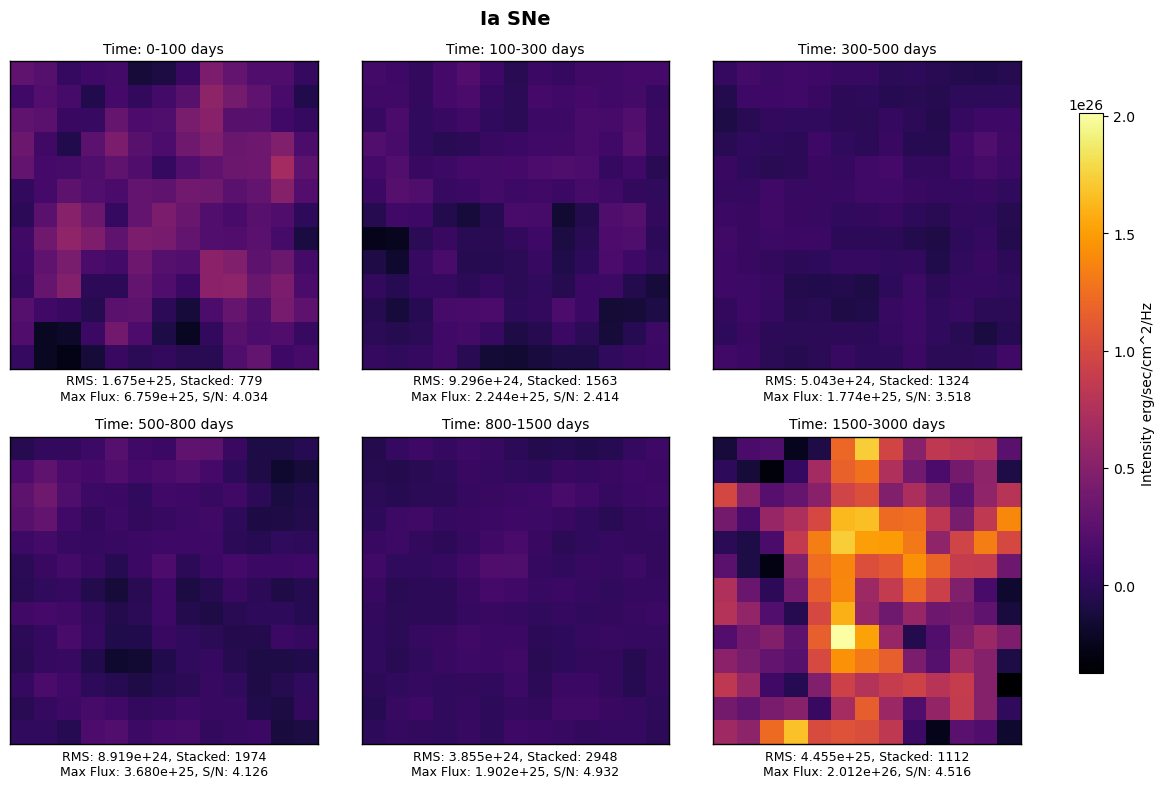

In [89]:
plot_stacked_arrays(stacked_ia_df, 'Ia SNe')

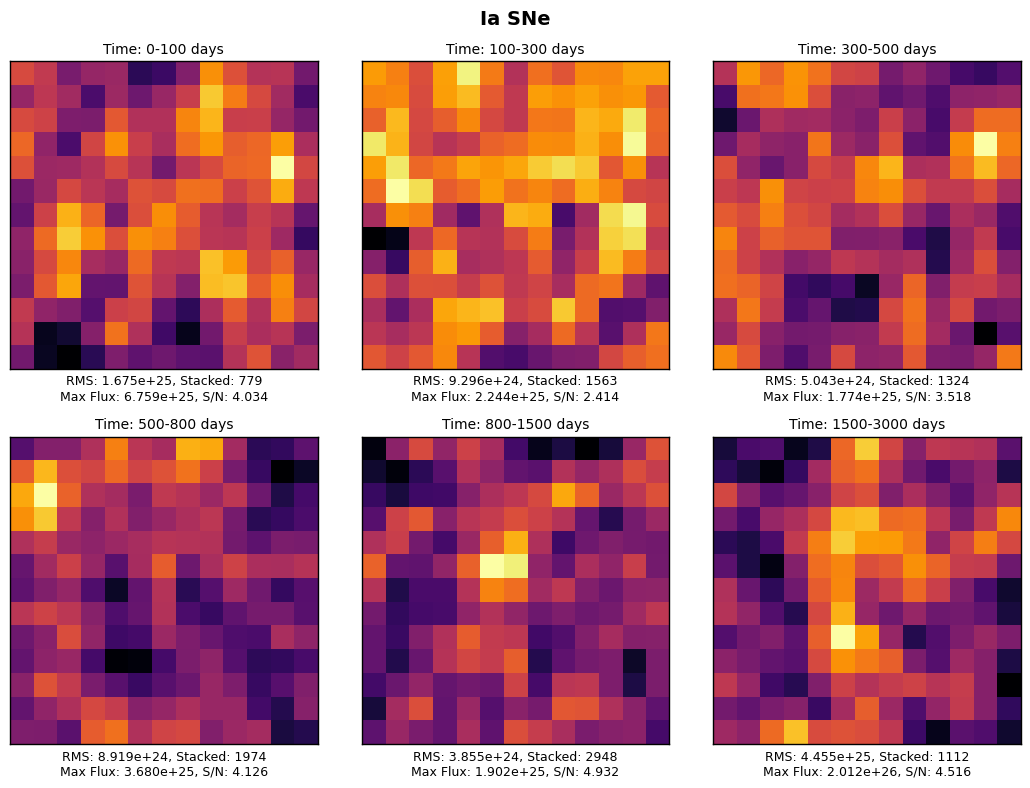

In [73]:
plot_stacked_arrays_individual_scaling(stacked_ia_df, 'Ia SNe')

C:\Users\Jack Pope\AppData\Local\Temp\ipykernel_21660\2891524889.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Ensure space for the color bar


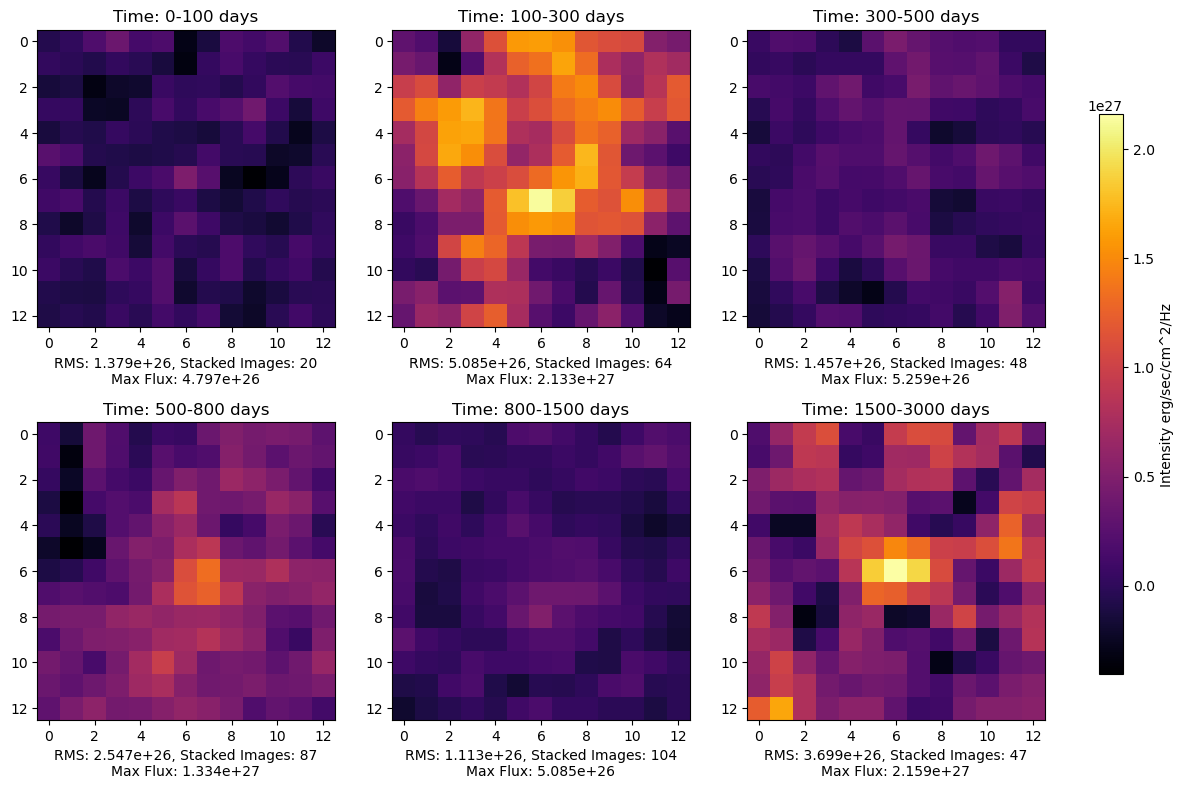

In [109]:
plot_stacked_arrays(stacked_iin_df)

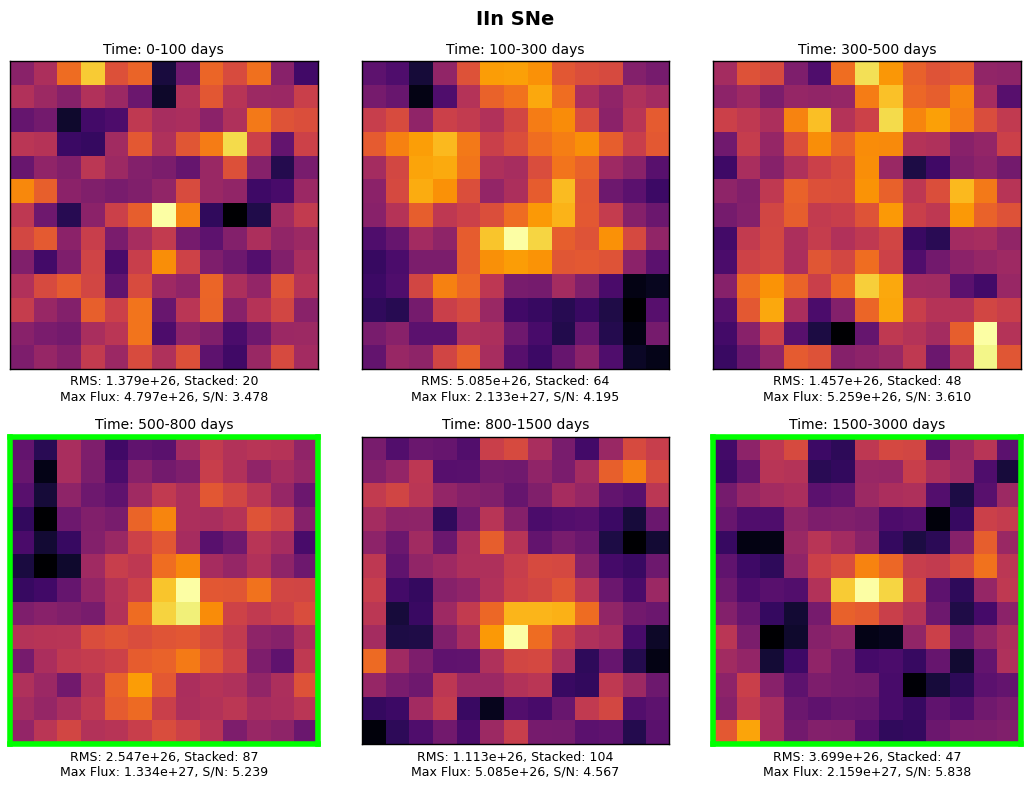

In [74]:
plot_stacked_arrays_individual_scaling(stacked_iin_df, 'IIn SNe')

C:\Users\Jack Pope\AppData\Local\Temp\ipykernel_21660\2891524889.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Ensure space for the color bar


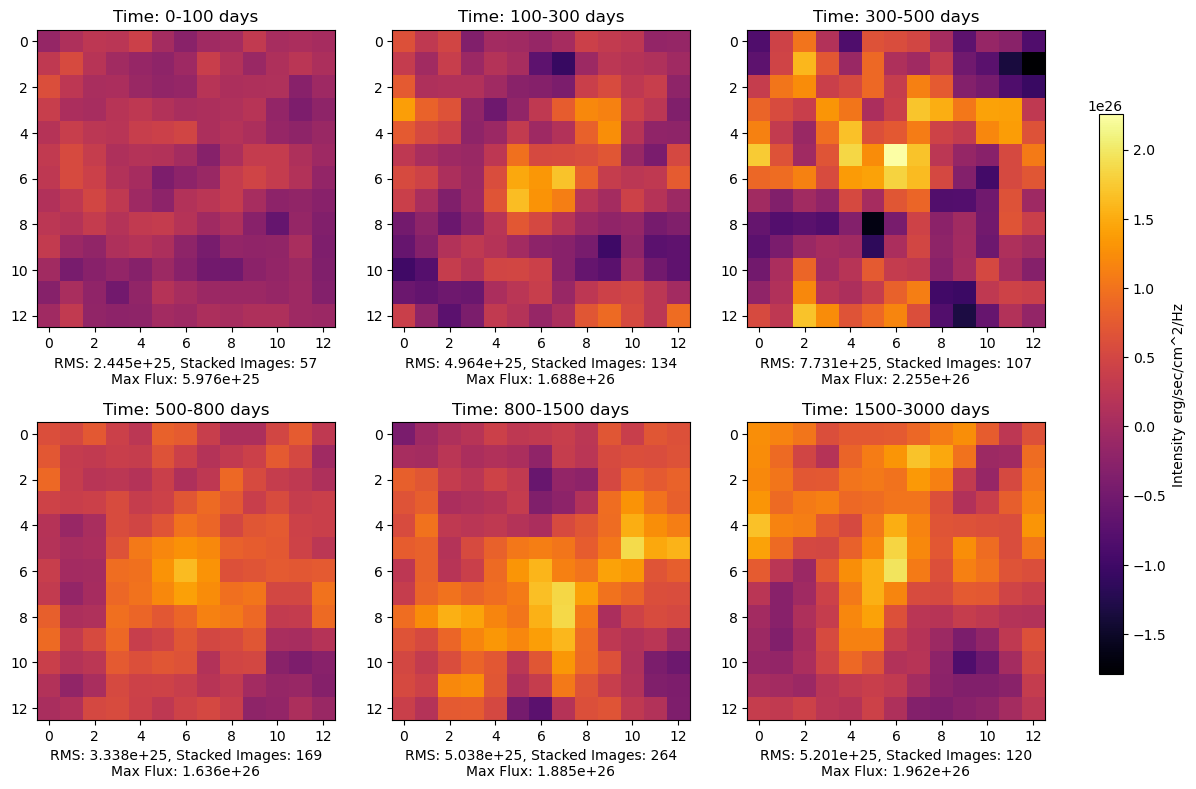

In [110]:
plot_stacked_arrays(stacked_stripped_envelope_df)

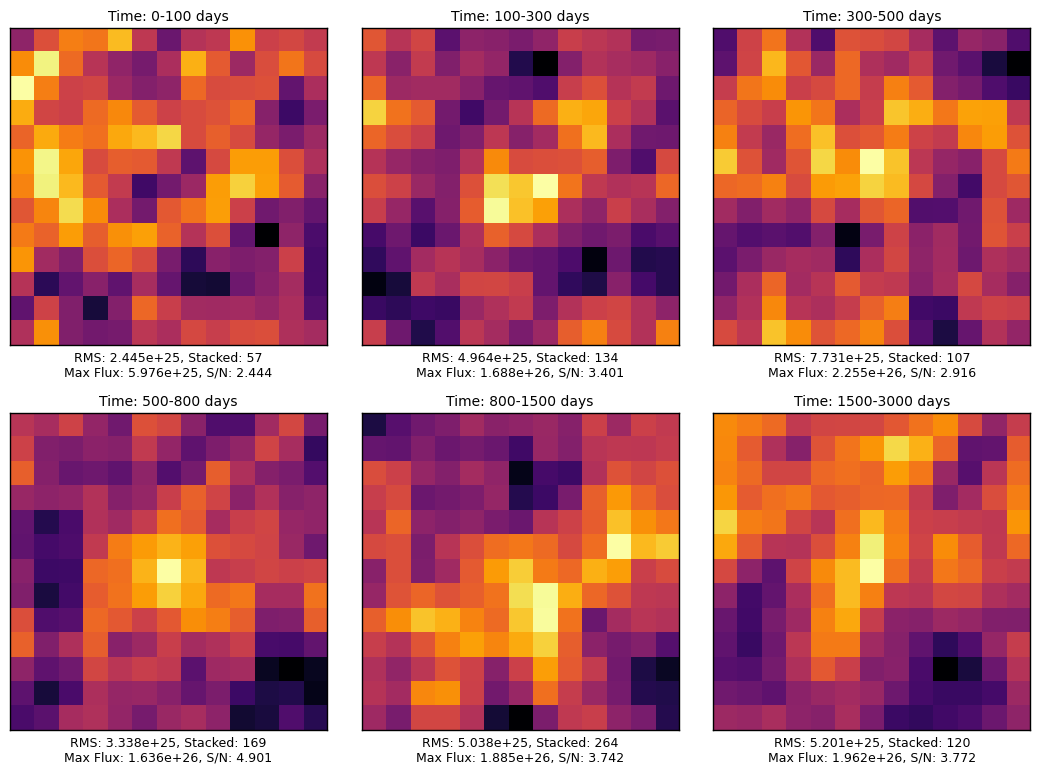

In [75]:
plot_stacked_arrays_individual_scaling(stacked_stripped_envelope_df)

C:\Users\Jack Pope\AppData\Local\Temp\ipykernel_21660\2891524889.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Ensure space for the color bar


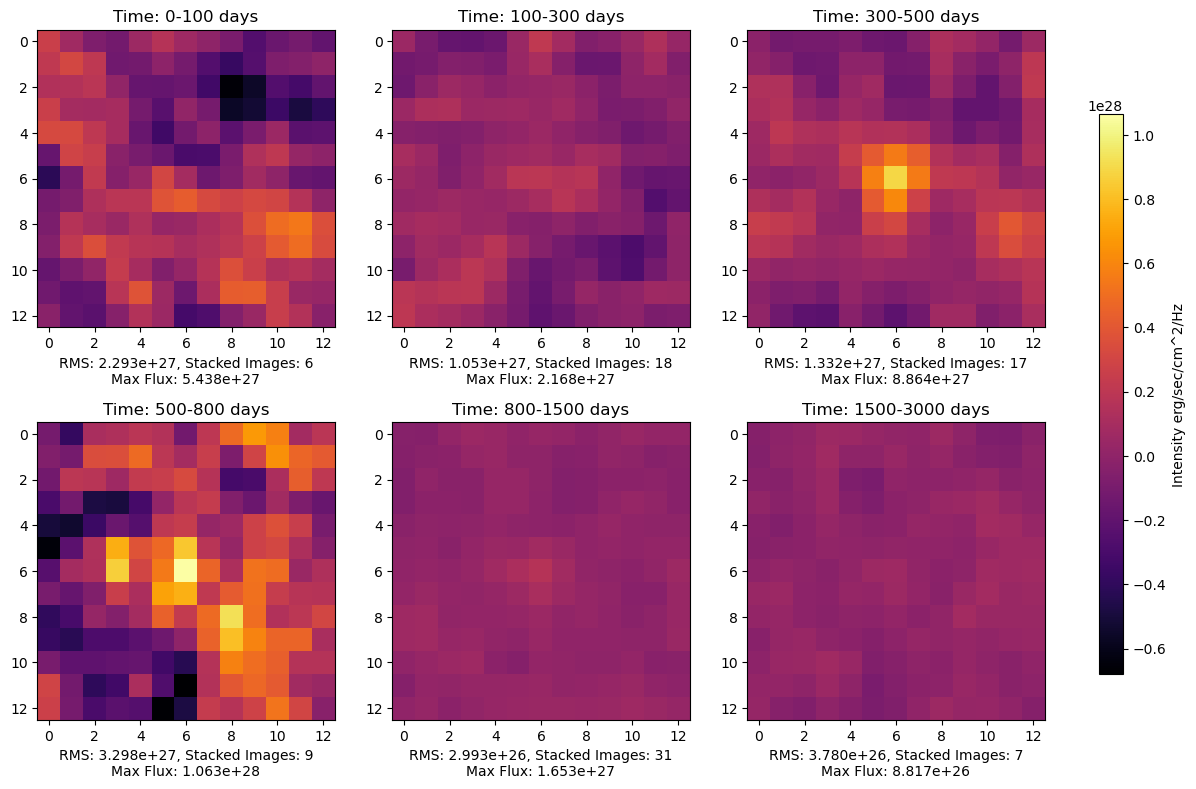

In [112]:
plot_stacked_arrays(stacked_tde_df)

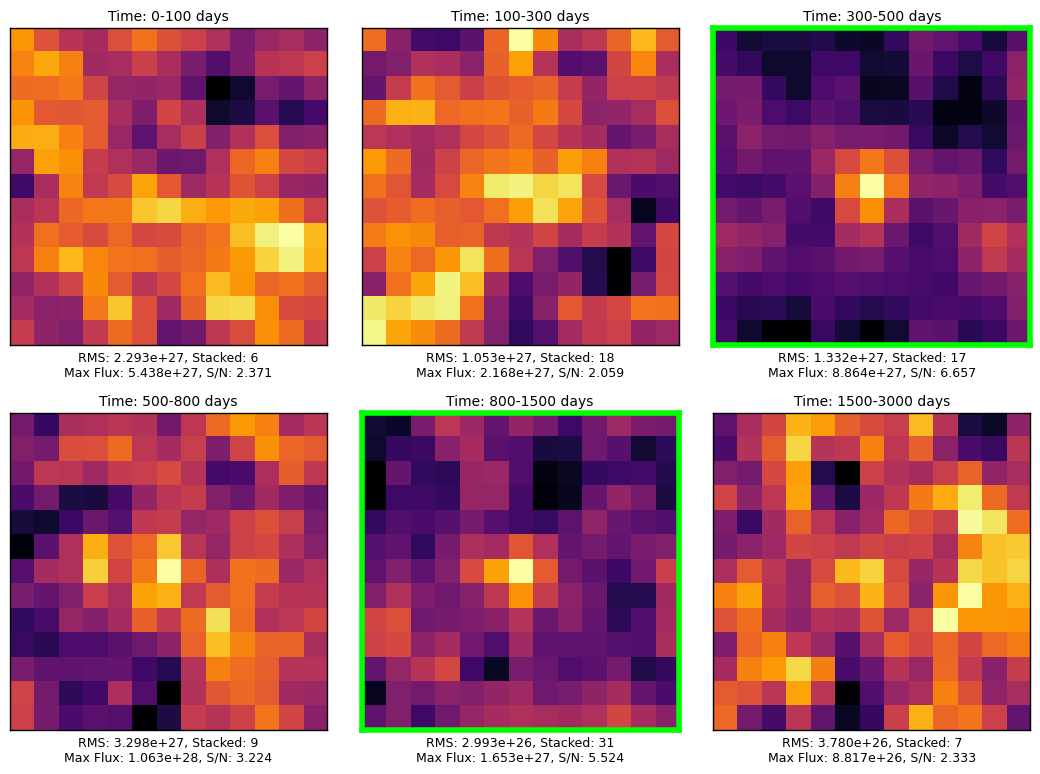

In [76]:
plot_stacked_arrays_individual_scaling(stacked_tde_df)

C:\Users\Jack Pope\AppData\Local\Temp\ipykernel_21660\2891524889.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Ensure space for the color bar


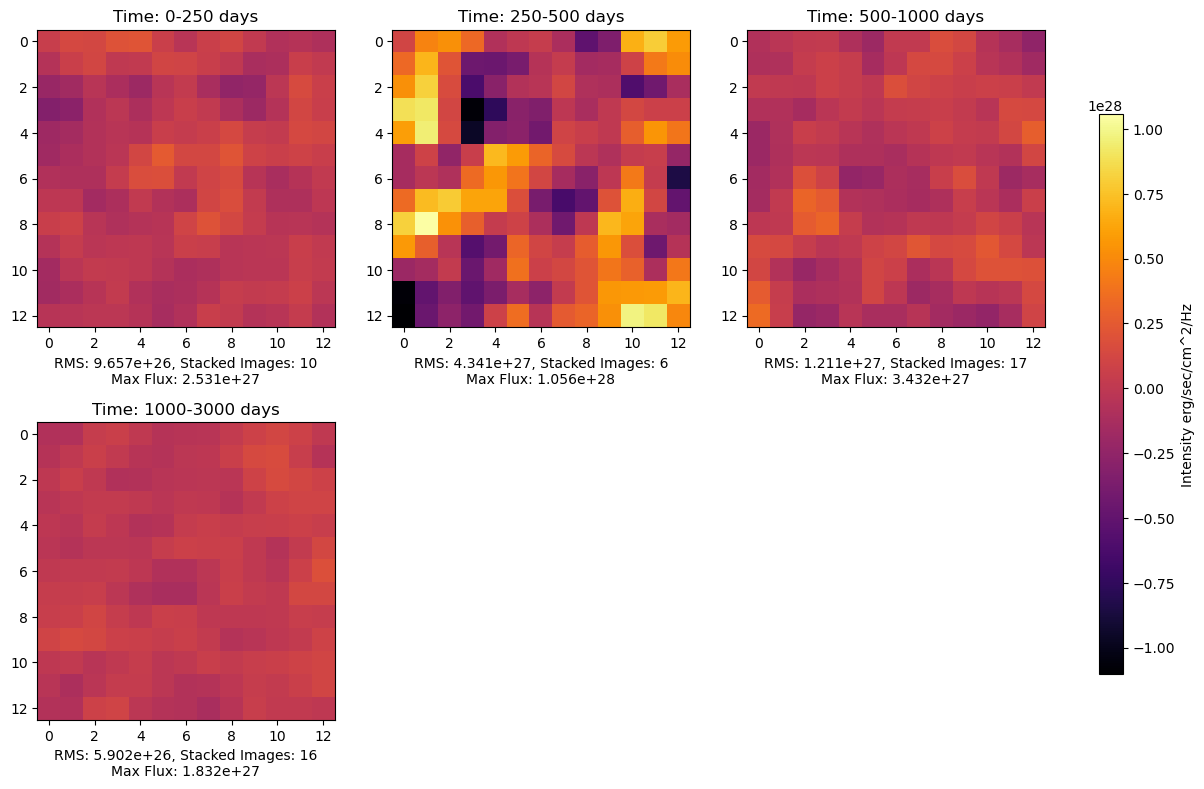

In [114]:
plot_stacked_arrays(stacked_ibn_icn_df)

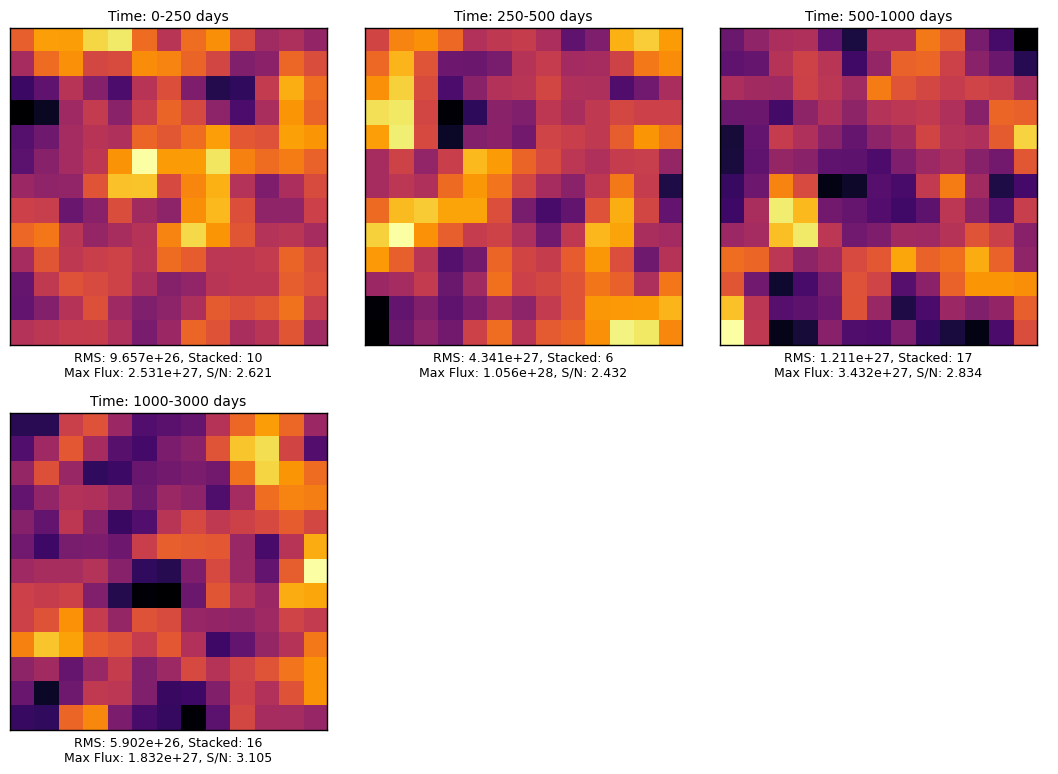

In [77]:
plot_stacked_arrays_individual_scaling(stacked_ibn_icn_df)

C:\Users\Jack Pope\AppData\Local\Temp\ipykernel_21660\2891524889.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Ensure space for the color bar


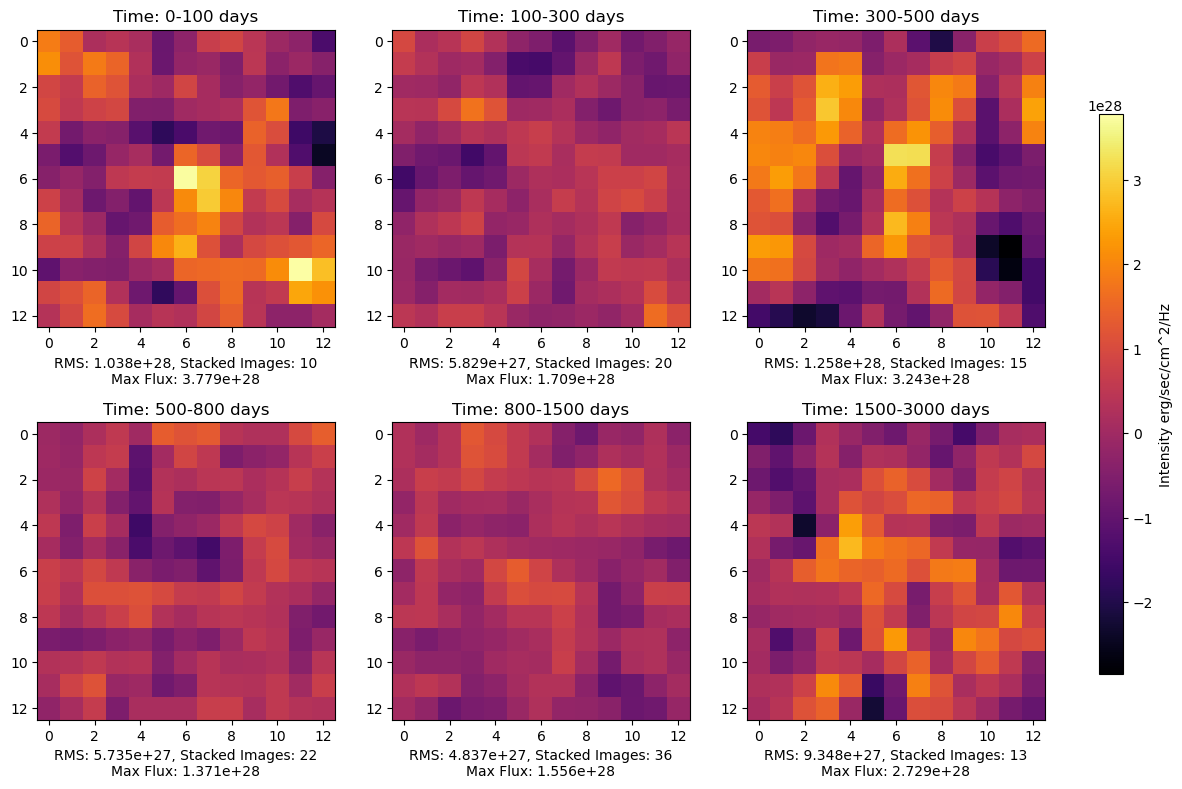

In [116]:
plot_stacked_arrays(stacked_slsn1_df)

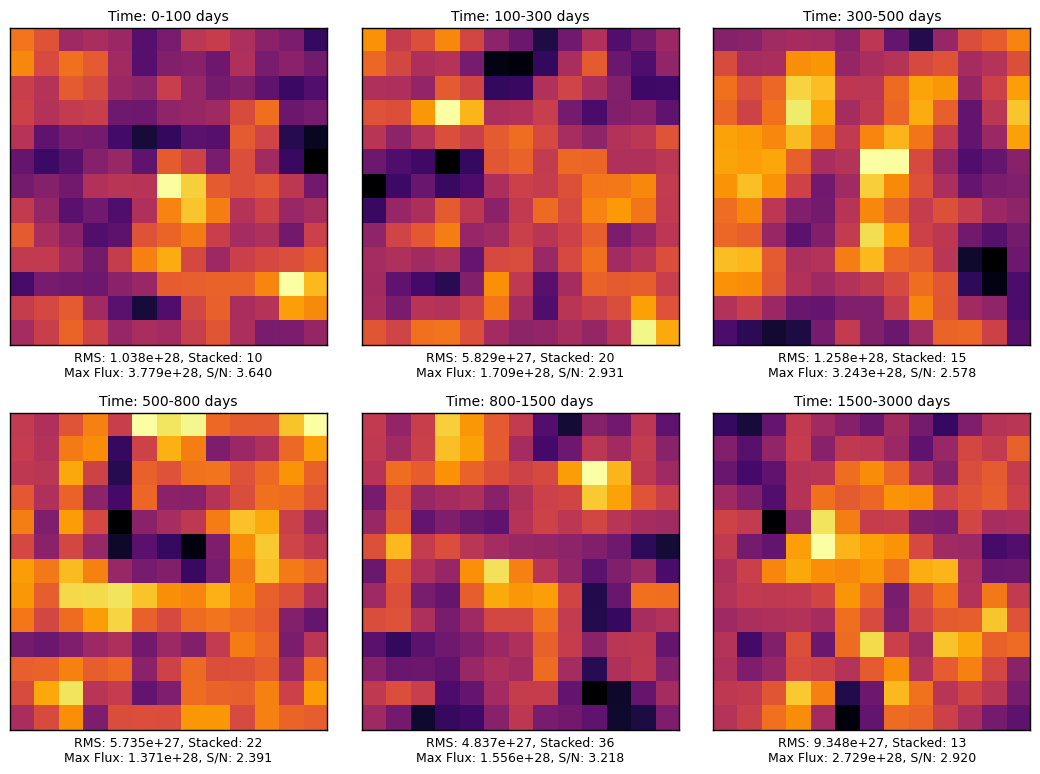

In [78]:
plot_stacked_arrays_individual_scaling(stacked_slsn1_df)

C:\Users\Jack Pope\AppData\Local\Temp\ipykernel_21660\2891524889.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Ensure space for the color bar


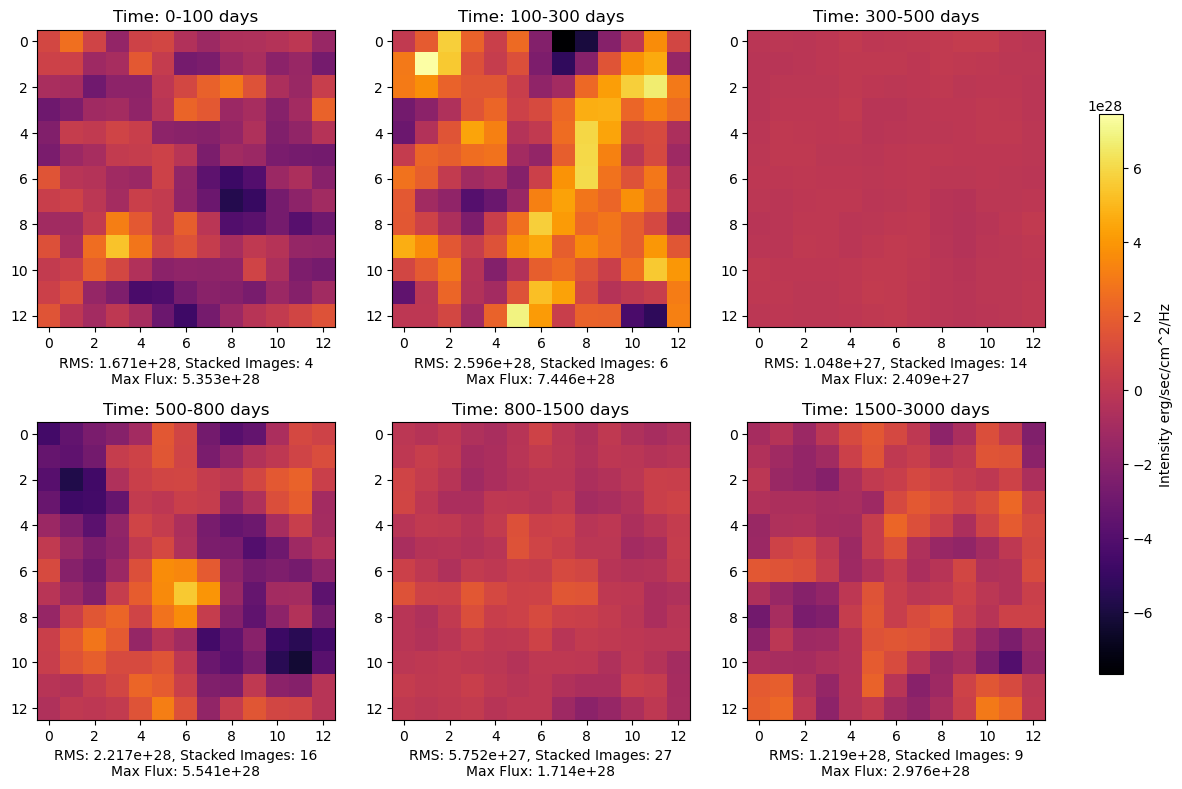

In [118]:
plot_stacked_arrays(stacked_slsn2_df)

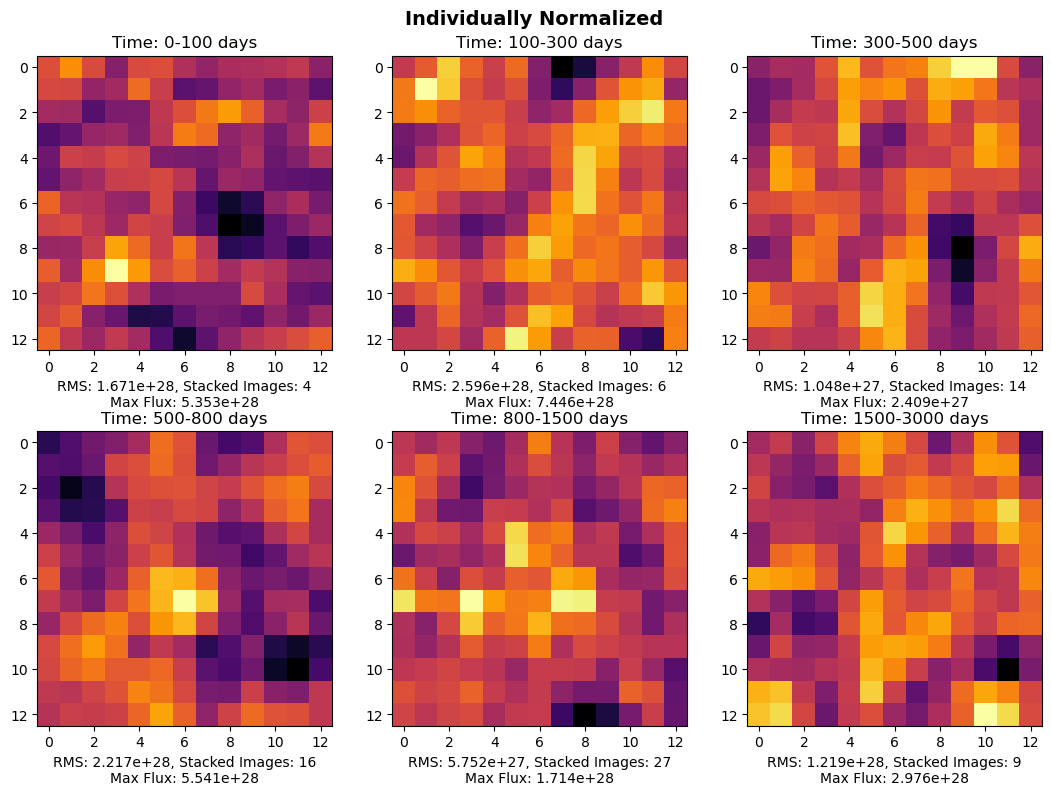

In [120]:
plot_stacked_arrays_individual_scaling(stacked_slsn2_df)